### Coursework 2

In this coursework you will be aiming to complete two classification tasks. 
Both the classification tasks relate to text classification tasks. 

One task is to be solved using Support Vector Machines. The other has to be solved using Boosting.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single zip file. You could have additional functions implemented that you require for carrying out each task.


#### Task 1

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train an SVM based classifier to obtain train and check on the sample test dataset provided. The method will be evaluated also against an external test set. Please do not hardcode any dimensions or number of samples while writing the code. It should be possible to automate the testing and hardcoding values does not allow for automated testing. 

You are allowed to use scikit-learn to implement the SVM. However, you are expected to write your own kernels.

You are allowed to use the existing library functions such as scikit-learn or numpy for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. Refer to the documentation provided [here](https://scikit-learn.org/stable/modules/svm.html) at 1.4.6.2 and an example [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html) for writing your own kernels.

Details regarding the marking have been provided in the coursework specification file. Ensure that the code can be run with different test files. 

#### Process the text and obtain a bag of words-based features 

In [7]:
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer

from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from scipy import sparse

In [8]:
def extract_bag_of_words_train_test(train_file, test_file):
    # Read the CSV file and extract Bag of Words Features
    import pandas as pd
    import regex as re
    import nltk
    from nltk.stem import PorterStemmer
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    def stem_removal(text):  
        stemmer = PorterStemmer()
        tokens = []
        for token in text.split():
            tokens.append(stemmer.stem(token))
        return tokens
    
    def preprocessor(text):
        text = re.sub('<[^>]*>', '', text) # Remove HTML markup
        text = re.sub('[\W]+', ' ', text.lower())
        return text
    
    tfidf = TfidfVectorizer(tokenizer=stem_removal,
                            preprocessor=preprocessor) # Performs better than CountVectorizer()
    
    df_train = pd.read_csv(train_file)
    df_train = df_train.sample(frac=1).reset_index(drop=True) # Shuffling to remove any bias
    df_test = pd.read_csv(test_file)
    
    X_train = tfidf.fit_transform(df_train['review'])
    y_train = df_train['sentiment'].apply(lambda sent: 1 if sent == "positive" else 0).values
    
    X_test = tfidf.transform(df_test['review'])
    y_test = df_test['sentiment'].apply(lambda sent: 1 if sent == "positive" else 0).values
    
    return (X_train,y_train,X_test,y_test)

In [9]:
class SVMClassifier:
    def __init__(self, kernel='custom_poly', degree=3, coef=0.4444444444444444):
        import numpy as np
        from sklearn import svm
        #implement initialisation
        self.kernel_lst = ['linear', 'rbf', 'poly', 'sigmoid']
        self.kernel = kernel
        self.classifier = None
        self.train = None
        
        # PARAMETER INITIALISATION
        self.coef = coef
        self.degree = degree
        
    # define your own kernel here
    # Refer to the documentation here: https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html
    
    # CUSTOM KERNELS
    def log(self, X, y):
        degree = self.degree
        if degree is None:
            degree = 1
        return -np.log(euclidean_distances(X, y)**degree + 1)
    
    def laplacian(self, X, y):        
        if sparse.issparse(X):
            sigma = np.sqrt(X.shape[1] * np.var(X.toarray()))
        else:
            sigma = np.sqrt(X.shape[1] * np.var(X))
        return -euclidean_distances(X, y)/sigma
    
    def poly(self, X, y):
        degree = self.degree
        coef = self.coef
        
        if degree is None:
            degree = 1
        if coef is None:
            coef = 0
            
        X = X.A
        y = y.A
        gamma = 1.0/(X.shape[1] * np.var(X))
        return (gamma*X.dot(y.T) + coef)**degree
    
    # ESTIMATOR FUNCTIONS
    def get_params(self, deep = True):
        return {'degree': self.degree, 'coef':self.coef}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X,y):
        # training of the SVM
        # Ensure you call your own defined kernel here
        if self.kernel in self.kernel_lst:
            svc = svm.SVC(kernel=self.kernel)
            svc.fit(X, y)
        else:
            svc = svm.SVC(kernel='precomputed')
            if self.kernel == 'log':
                svc.fit(self.log(X, X), y)
            elif self.kernel == 'laplacian':
                svc.fit(self.laplacian(X, X), y)
            elif self.kernel == 'custom_poly':
                svc.fit(self.poly(X, X), y)

        self.train = X
        self.classifier = svc

    def predict(self, X):
        # prediction routine for the SVM
        svc = self.classifier
        X_train = self.train

        if self.kernel in self.kernel_lst:
            return svc.predict(X)
        else:
            if self.kernel == 'log':
                return svc.predict(self.log(X, X_train))
            elif self.kernel == 'laplacian':
                return svc.predict(self.laplacian(X, X_train))
            elif self.kernel == 'custom_poly':
                return svc.predict(self.poly(X, X_train))


### Cross Validation for Hyper-Parameter Tuning using GridSearch

In [10]:
# CROSS-VALIDATION FOR HYPER PARAMETER SELECTION
parameters = {'kernel': ['custom_poly'], 
              'degree': [1, 2, 3],
              'coef': np.linspace(0,1,10)}
svc = SVMClassifier()
clf = GridSearchCV(svc, parameters, verbose=False, cv=2, scoring="accuracy")

'''UNCOMMENT THE LINES BELOW'''
#(X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
#clf.fit(X_train, Y_train)
#print(clf.best_params_)

#{'coef': 0.4444444444444444, 'degree': 3, 'kernel': 'custom_poly'}

'UNCOMMENT THE LINES BELOW'

### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [11]:
def test_func_svm(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score  
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    sc = SVMClassifier()
    sc.fit(X_train, Y_train)
    Y_Pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_Pred)
    print("Accuracy:",acc)
    return acc

In [12]:
acc = test_func_svm("movie_review_train.csv", "movie_review_test.csv")

Accuracy: 0.8826666666666667


### Visualising Comparison of Kernel Performance

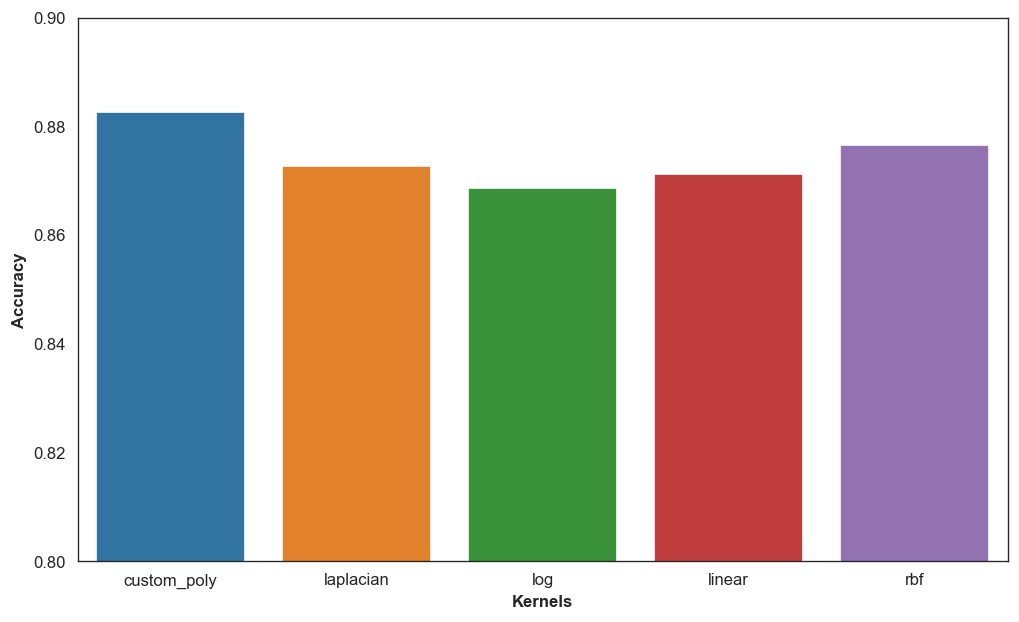

In [14]:
X_train, Y_train, X_test, Y_test = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")

kernel_lst = ['custom_poly', 'laplacian', 'log', 'linear', 'rbf']
kernel_accuracy = []
for kernel in kernel_lst:
    sc = SVMClassifier(kernel=kernel)
    sc.fit(X_train, Y_train)
    Y_Pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_Pred)
    kernel_accuracy.append(acc)

df_temp = pd.DataFrame([kernel_accuracy], columns=kernel_lst)
df_kernel = pd.DataFrame([], columns=kernel_lst, dtype=object)
df_kernel = df_kernel.append(df_temp, ignore_index=True)

plt.figure(figsize=(10,6), dpi=120)
sns.set_style('white')
plot = sns.barplot(data=df_kernel)
#kernelplot.set(xlabel='Kernels', ylabel='Accuracy')
plt.xlabel('Kernels', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0.8,0.9)
plt.show()

### Error Analysis of Misclassified Reviews

In [15]:
sc = SVMClassifier()
sc.fit(X_train, Y_train)
Y_Pred = sc.predict(X_test)

df_test = pd.read_csv('movie_review_test.csv')
df_test['review'][Y_Pred != Y_test] # Identifying all misclassified reviews

0       Not a movie for everyone, but this movie is in...
2       RKO Radio Pictures made a real classic in 1947...
3       "Transylvania 6-5000" is an insignificant but ...
18      Previously, I wrote that I loved "Titanic", cr...
23      Jonathan Rivers (Michael Keaton) suddenly beco...
                              ...                        
1466    Just finished this impressively nutty affair a...
1475    THE BRAIN THAT WOULDN'T DIE was considered so ...
1492    I just watched this movie on Showtime. Quite b...
1494    I am new at this, so bear with me please. I am...
1497    I think this movie is different apart from mos...
Name: review, Length: 176, dtype: object

In [16]:
df_test['review'][Y_Pred != Y_test][1497] # Positive review which contains words 
                                          # associated with negative reviews
                                          # 'sucks', 'boring', 'mess', 'tired', 'ordinary'

"I think this movie is different apart from most films I've seen. It was exciting in a way, and no matter what others say, I say, I was surprised about the final solution. Certainly didn't see it coming!! Although it's sad, it's worth watching.. I can't think of any movie that would be like this! Actors knew what they were doing. If you say this movie sucks, you say probably what most people would say. But, if someone says that this movie is ordinary, I absolutely don't agree. And Norman Reedus should be more noticed.<br /><br />Maybe I'm freak but I liked this very much. It was kind of mess, but who cares? I'm tired of boring and ordinary movies."

In [17]:
# Calculating average number of words in misclassified text
df_test['review'][Y_Pred != Y_test].str.split().str.len().sum()/len(df_test['review'][Y_Pred != Y_test])

223.83522727272728

In [18]:
# Calculating average number of words in correctly classified text
df_test['review'][Y_Pred == Y_test].str.split().str.len().sum()/len(df_test['review'][Y_Pred == Y_test])

239.68353474320242

### Task 2

In this task you need to implement a boosting based classifier that can be used to classify the images. 

Details regarding the marking for the coursework are provided in the coursework specification file. Please ensure that your code will work with a different test file than the one provided with the coursework.

Note that the boosting classifier you implement can include decision trees from scikit-learn or your own decision trees. Use the same sentiment analysis dataset for evaluation.

In [24]:
class BoostingClassifier:
    # You need to implement this classifier. 
    def __init__(self, num_clfs=50):
        #implement initialisation
        self.num_clfs = num_clfs
        self.trained_clfs = []
    
    def saame(self, X, y):
        # implement SAAME algorithm (AdaBoost)
        clfs = []
        N = X.shape[0]
        W = np.full(N, (1 / N), dtype=np.float64)
        
        for _ in range(self.num_clfs):
            clf = DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=W)
            error = sum(W * np.where(clf.predict(X) != y, 1, 0)) / sum(W)
            alpha = np.log((1 - error) / error)
            W = np.array([W[i] * np.exp(alpha * np.where(clf.predict(X) != y, 1, 0))[i] for i in range(W.shape[0])])
            clfs.append((clf, alpha))
        return clfs

    def fit(self, X, y):
        self.trained_clfs = self.saame(X, y)

    def predict(self, X):
        # Predict
        classes = np.array([0, 1])
        preds = np.zeros((X.shape[0], 1))

        for cls in classes:
            class_preds = np.zeros((X.shape[0], 1))
            
            for i in range(self.num_clfs):    
                clf, alpha = self.trained_clfs[i]
                class_preds += alpha * np.expand_dims(np.where(clf.predict(X) == cls, 1, 0), axis=1)
                
            preds = np.append(preds, class_preds, axis=1)
        
        pred_idx = np.argmax(preds, axis=1) - 1
        y_pred = classes[pred_idx]
        
        return y_pred

### Test function that will be called to evaluate your code. Separate test dataset will be provided

Do not modify the code below. Please write your code above such that it can be evaluated by the function below. You can modify your code above such that you obtain the best performance through this function. 

In [20]:
def test_func_boosting(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score    
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    bc = BoostingClassifier()
    bc.fit(X_train, Y_train)
    Y_Pred = bc.predict(X_test)    
    acc = accuracy_score(Y_test, Y_Pred)
    return acc

In [21]:
acc = test_func_boosting("movie_review_train.csv", "movie_review_test.csv")

### Visualisation of Comparison of Number of Classifiers 

In [26]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

(X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")

# K-Fold cross validation
k_fold = KFold(n_splits=5)
num_clfs_ = list(range(10, 100, 10))
mean_accs = []

for n in num_clfs_:
    accs = []
    for train_indices, test_indices in k_fold.split(X_train[:800]):
        clf = BoostingClassifier(num_clfs=n)
        clf.fit(X_train[train_indices], Y_train[train_indices])
        y_pred = clf.predict(X_train[test_indices])
        acc = accuracy_score(Y_train[test_indices], y_pred)
        accs.append(acc)
    
    mean_accs.append(np.mean(accs))
    print(n, '> AVG accuracy: ', round(np.mean(accs), 2))


10 > AVG accuracy:  0.71
20 > AVG accuracy:  0.73
30 > AVG accuracy:  0.73
40 > AVG accuracy:  0.72
50 > AVG accuracy:  0.73
60 > AVG accuracy:  0.74
70 > AVG accuracy:  0.75
80 > AVG accuracy:  0.74
90 > AVG accuracy:  0.74


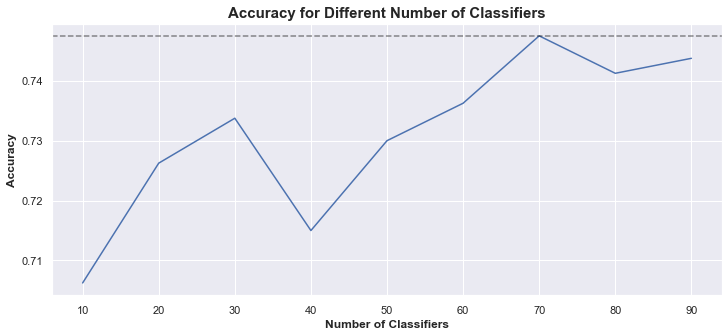

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
plt.figure(figsize=(12,5))
plt.plot(num_clfs_, mean_accs)
plt.axhline(max(mean_accs), color='k', alpha=0.5, linestyle='--')
plt.xlabel("Number of Classifiers", fontweight='bold')
plt.ylabel("Accuracy", fontweight='bold')
plt.title("Accuracy for Different Number of Classifiers", size=15, fontweight='bold')
plt.show()

### Error Analysis of Misclassified Reviews

In [ ]:
bc = BoostingClassifier(num_clfs=50)
bc.fit(X_train, Y_train)
Y_Pred = sc.predict(X_test)

df_test = pd.read_csv('movie_review_test.csv')
df_test['review'][Y_Pred != Y_test] # Identifying all misclassified reviews

In [ ]:
df_test['review'][Y_Pred != Y_test][3] # Negative review which contains words 
                                       # associated with positive reviews
                                       # 'funny', 'charming', 'chuckle', 'wholesome', 'succesful'

In [ ]:
# Calculating average number of words in misclassified text
df_test['review'][Y_Pred != Y_test].str.split().str.len().sum()/len(df_test['review'][Y_Pred != Y_test])

In [ ]:
# Calculating average number of words in correctly classified text
df_test['review'][Y_Pred == Y_test].str.split().str.len().sum()/len(df_test['review'][Y_Pred == Y_test])